# IRK schemes with Gauss-Legendre nodes: Solar-System problem

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Definition-of-the-N-body-problem">
             Definition of the N-body problem</a></li>

<li><a href="#Initial-value-problem:-16-body-problem-(Solar-System)">
             Initial value problem: 16-body problem (Solar System)</a></li>

<li><a href="#Integration-with-IRKGL16">
              Integration with IRKGL16</a></li>
              
<li><a href="#Integration-with-IRKNGL16">
              Integration with IRKNGL16</a></li>            

<li><a href="#Error-in-energy">
             Error-in-energy</a></li> 
    
<li><a href="#Benchmarks">
             Benchmarks</a></li> 

</ul>  


## Loading packages

In [1]:
using IRKGaussLegendre
using LinearAlgebra
using Plots
using BenchmarkTools

<a href="#top">Back to the top</a>

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem



**Equations**


The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:

\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}

This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm).
\end{equation*}


**State variables and parameters**

We implement the state variables as an array with three indices:

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{3\times N \times 2}, 
\end{equation*}

where $u[i,j,k] \in \mathbb{R}$:

- The index $i$ takes the values $y=1,2,3$, referring to the coordinate $x,y,z$ respectively.
- The index $j$ takes the values $j=1,2,\dots,N$, referring to the corresponding planet.
- The index $k$ takes the values $k=1,2$, referring to the position if $k=1$ and the speed if $k=2$.

The vector with the constant parameters of the problem is::

\begin{equation*}
p = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N,
\end{equation*}

where $Gm_i$ corresponds to the mass of the $i$th body multiplied by the universal gravity constant $G$.


<a href="#top">Back to the top</a>

## Initial value problem: 15-body problem (Solar System)

We consider $N=16$ bodies of solar system: the Sun, Mercury, Venus, the Earth, Mars, Jupiter, Saturn, Uranus, Neptune,  Pluto
the Moon, Ceres, Pallas, Vesta, Iris, Bamberga.
The initial values $u_0$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969).

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [3]:
include("../ODEProblems/Initial15Body.jl")
u0, Gm, bodylist = Initial15Body()
N = length(Gm)
size(u0)

(3, 15, 2)

<a href="#top">Back to the top</a>


## Integration with IRKGL16

Just to check that the output of the function NbodyODE has the expected type:

In [4]:
#include("../ODEProblems/Nbody.jl")
include("../ODEProblems/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
size(du0)

(3, 15, 2)

Set up of the problem and integrate with symplectic integrator IRKGL16 

#### Constant step-size

In [5]:
t0 = 0.
T = 1000. # Final time
dt = 5.0 # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

In [6]:
sol0=solve(prob,IRKGL16(simd=false),dt=dt,adaptive=false)
sol0.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  16696
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     2087
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [7]:
sol1=solve(prob,IRKGL16(simd=true),dt=dt,adaptive=false)
sol1.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  16488
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     2061
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [8]:
norm(sol0.u[end]-sol1.u[end])

8.657793519897786e-15

#### Adaptive step-size

In [9]:
sol2=solve(prob,IRKGL16(simd=false),adaptive=true,reltol=1e-16,abstol=1e-16)
sol2.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  16512
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     2064
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          123
Number of rejected steps:                          22

In [10]:
norm(sol0.u[end]-sol2.u[end])

4.401232264700196e-15

In [11]:
sol3=solve(prob,IRKGL16(simd=true),adaptive=true,reltol=1e-16,abstol=1e-16)
sol3.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  17984
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     2248
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          123
Number of rejected steps:                          22

In [12]:
norm(sol0.u[end]-sol3.u[end])

1.3352251170550285e-14

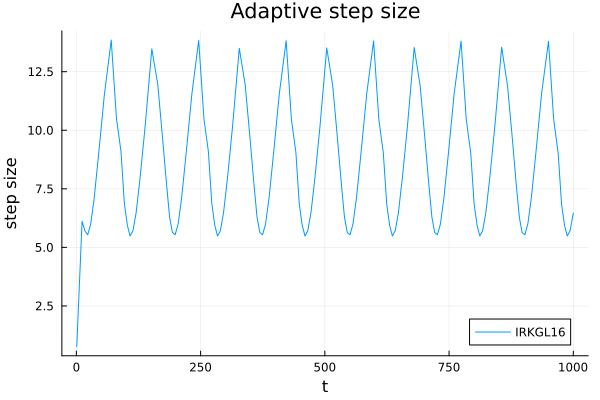

In [13]:
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(sol2.t[2:end],steps2, label="IRKGL16")

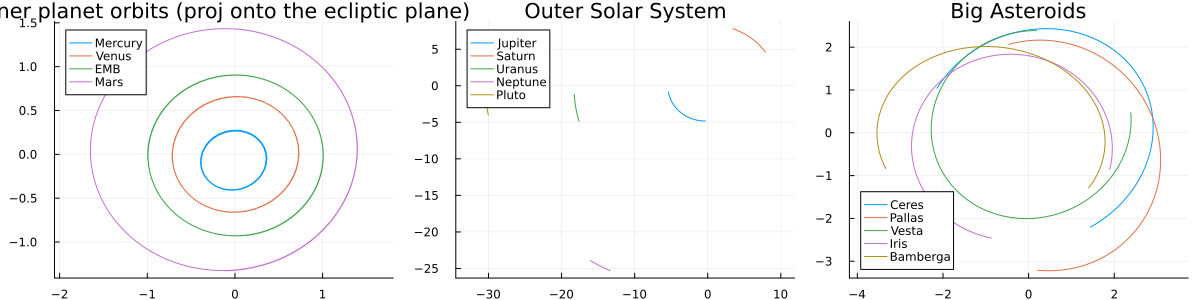

In [14]:
bodylist = ["Sun", "Mercury", "Venus", "EMB", "Mars", "Jupiter", "Saturn", 
            "Uranus", "Neptune", "Pluto",  "Ceres", "Pallas", "Vesta", 
             "Iris", "Bamberga"]
ulist0 = sol0.u
tlist0 = sol0.t


pl1 = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 2:5
 xlist  = map(u->u[1,j,1], ulist0)
 ylist  = map(u->u[2,j,1], ulist0)
 pl1 = plot!(xlist,ylist, label = bodylist[j])   
end   

pl2 = plot(title="Outer Solar System", 
          aspect_ratio=1)

for j = 6:10
 xlist  = map(u->u[1,j,1], ulist0)
 ylist  = map(u->u[2,j,1], ulist0)
 pl2 = plot!(xlist,ylist, label = bodylist[j])   
end  

pl3 = plot(title="Big Asteroids", 
          aspect_ratio=1)

for j = 11:15
 xlist  = map(u->u[1,j,1], ulist0)
 ylist  = map(u->u[2,j,1], ulist0)
 pl3 = plot!(xlist,ylist, label = bodylist[j])   
end  

 
plot(pl1,pl2,pl3, layout=(1,3), size=(1200,300))

<a href="#top">Back to the top</a>


## Integration with IRKNGL16

In [15]:
include("../ODEProblems/NbodyDyn.jl")
q0=u0[:,:,1]
v0=u0[:,:,2]
probdyn = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0,v0,tspan,Gm);

#### Constant step-size

In [16]:
sol12=solve(probdyn,IRKGL16(simd=false),dt=dt,adaptive=false)
sol12.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  11152
Number of function 2 evaluations:                  9552
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1194
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [17]:
sol13=solve(prob,IRKGL16(simd=false, second_order_ode=true),dt=dt,adaptive=false)
sol13.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  11152
Number of function 2 evaluations:                  9552
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1194
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [18]:
[norm(sol12.u[end].x[1]-sol13.u[end][:,:,1]),norm(sol12.u[end].x[2]-sol13.u[end][:,:,2])]

2-element Vector{Float64}:
 0.0
 0.0

In [19]:
sol14=solve(prob,IRKGL16(simd=true, second_order_ode=true),dt=dt,adaptive=false)
sol14.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  11120
Number of function 2 evaluations:                  9520
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1190
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [20]:
[norm(sol12.u[end].x[1]-sol14.u[end][:,:,1]),norm(sol12.u[end].x[2]-sol14.u[end][:,:,2])]

2-element Vector{Float64}:
 1.662018057449727e-14
 1.1800198719280593e-15

#### Adaptive step-size

In [21]:
sol15=solve(probdyn,IRKGL16(), dt=dt, adaptive=true,reltol=1e-16,abstol=1e-16)
sol15.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  10104
Number of function 2 evaluations:                  8952
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1119
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          121
Number of rejected steps:                          23

In [22]:
sol16=solve(prob, IRKGL16(second_order_ode=true), dt=dt, adaptive=true,reltol=1e-16,abstol=1e-16)
sol16.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  10104
Number of function 2 evaluations:                  8952
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1119
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          121
Number of rejected steps:                          23

In [23]:
[norm(sol15.u[end].x[1]-sol16.u[end][:,:,1]),norm(sol15.u[end].x[2]-sol16.u[end][:,:,2])]

2-element Vector{Float64}:
 0.0
 0.0

In [24]:
sol17=solve(prob, IRKGL16(simd=true,second_order_ode=true), dt=dt, adaptive=true,reltol=1e-16,abstol=1e-16)
sol17.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  10200
Number of function 2 evaluations:                  9048
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1131
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          121
Number of rejected steps:                          23

In [25]:
[norm(sol15.u[end].x[1]-sol17.u[end][:,:,1]),norm(sol15.u[end].x[2]-sol17.u[end][:,:,2])]

2-element Vector{Float64}:
 2.196767702253628e-14
 1.2159867797959641e-15

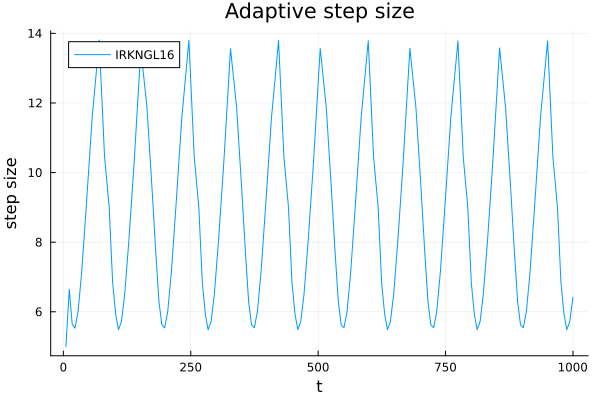

In [26]:
steps15 =sol15.t[2:end]-sol15.t[1:end-1]
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(sol15.t[2:end],steps15, label="IRKNGL16")

<a href="#top">Back to the top</a>


## Error in energy

In [27]:
[sol0.retcode sol1.retcode sol12.retcode sol13.retcode sol14.retcode]

1×5 Matrix{SciMLBase.ReturnCode.T}:
 ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1

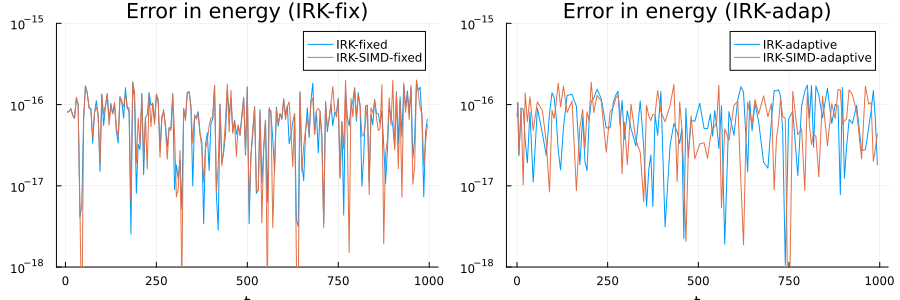

In [28]:
E0=NbodyEnergy(BigFloat.(u0),BigFloat.(Gm))
yrange=(1e-18, 1e-15)

ulist = sol0.u[2:end-1]
tlist = sol0.t[2:end-1]
EnergyErrors=[NbodyEnergy(BigFloat.(ulist[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[2:end-1]
tlist1 = sol1.t[2:end-1]
EnergyErrors1=[NbodyEnergy(BigFloat.(ulist1[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[2:end-1]
tlist2 = sol2.t[2:end-1]
EnergyErrors2=[NbodyEnergy(BigFloat.(ulist2[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist2)]

ulist3 = sol3.u[2:end-1]
tlist3 = sol3.t[2:end-1]
EnergyErrors3=[NbodyEnergy(BigFloat.(ulist3[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist3)]

pl1=plot( tlist[1:end],abs.(EnergyErrors), xlabel="t", yscale=:log10, ylims=yrange,
          title="Error in energy (IRK-fix)", label="IRK-fixed")
plot!(pl1, tlist1[1:end],abs.(EnergyErrors1), label="IRK-SIMD-fixed")

pl2=plot(tlist2[1:end],abs.(EnergyErrors2),  xlabel="t",  yscale=:log10, ylims=yrange,
           title="Error in energy (IRK-adap)", label="IRK-adaptive")
plot!(pl2, tlist3[1:end],abs.(EnergyErrors3), label="IRK-SIMD-adaptive")

plot(pl1, pl2, layout=(1,2), size=(900,300))

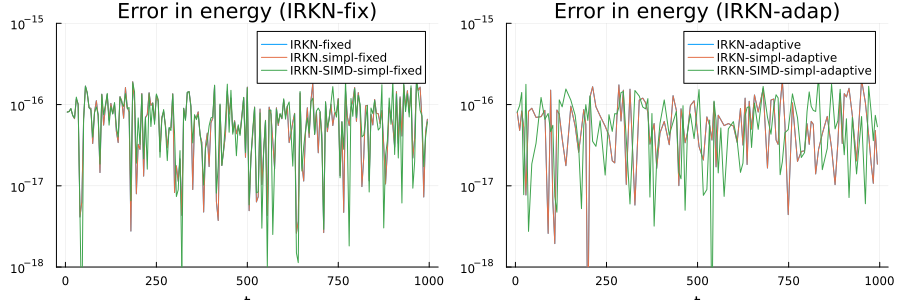

In [29]:
E0=NbodyEnergy(BigFloat.(u0),BigFloat.(Gm))
yrange=(1e-18, 1e-15)

ulist12 = sol12.u[2:end-1]
tlist12 = sol12.t[2:end-1]
EnergyErrors12=[NbodyEnergy3(BigFloat.(ulist12[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist12)]

ulist13 = sol13.u[2:end-1]
tlist13 = sol13.t[2:end-1]
EnergyErrors13=[NbodyEnergy(BigFloat.(ulist13[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist13)]

ulist14 = sol14.u[2:end-1]
tlist14 = sol14.t[2:end-1]
EnergyErrors14=[NbodyEnergy(BigFloat.(ulist14[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist14)]

ulist15 = sol15.u[2:end-1]
tlist15 = sol15.t[2:end-1]
EnergyErrors15=[NbodyEnergy3(BigFloat.(ulist15[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist15)]

ulist16 = sol16.u[2:end-1]
tlist16 = sol16.t[2:end-1]
EnergyErrors16=[NbodyEnergy(BigFloat.(ulist16[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist16)]

ulist17 = sol17.u[2:end-1]
tlist17 = sol17.t[2:end-1]
EnergyErrors17=[NbodyEnergy(BigFloat.(ulist17[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist17)]


pl1=plot(tlist12[1:end],abs.(EnergyErrors12), xlabel="t", yscale=:log10, ylims=yrange,
         title="Error in energy (IRKN-fix)", label="IRKN-fixed")
plot!(pl1, tlist13[1:end],abs.(EnergyErrors13), label="IRKN.simpl-fixed")
plot!(pl1, tlist14[1:end],abs.(EnergyErrors14), label="IRKN-SIMD-simpl-fixed")

pl2=plot(tlist15[1:end],abs.(EnergyErrors15),  xlabel="t", yscale=:log10, ylims=yrange,
          title="Error in energy (IRKN-adap)", label="IRKN-adaptive")
plot!(pl2, tlist16[1:end],abs.(EnergyErrors16), label="IRKN-simpl-adaptive")
plot!(pl2, tlist17[1:end],abs.(EnergyErrors17), label="IRKN-SIMD-simpl-adaptive")

plot(pl1, pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>


## Bechmarks

### IRKGL16

#### Constant step-size

In [30]:
@btime solve(prob,IRKGL16(simd=false),dt=dt,adaptive=false, save_everystep=false)
@show sol0.stats.naccept

  25.541 ms (308 allocations: 61.14 KiB)
sol0.stats.naccept = 200


200

In [31]:
@btime solve(prob,IRKGL16(simd=true),dt=dt,adaptive=false, save_everystep=false)
@show sol1.stats.naccept

  5.069 ms (290 allocations: 109.22 KiB)
sol1.stats.naccept = 200


200

#### Adaptive step-size

In [32]:
@btime solve(prob,IRKGL16(),adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol2.stats.naccept

  26.640 ms (660 allocations: 235.06 KiB)
sol2.stats.naccept = 123


123

In [33]:
@btime solve(prob,IRKGL16(simd=true),adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol3.stats.naccept

  5.530 ms (642 allocations: 263.89 KiB)
sol3.stats.naccept = 123


123

### IRKNGL16

#### Constant step-size

In [34]:
@btime solve(probdyn,IRKGL16(simd=false),dt=dt,adaptive=false, save_everystep=false)
@show sol12.stats.naccept

  29.299 ms (136 allocations: 48.89 KiB)
sol12.stats.naccept = 200


200

In [35]:
@btime solve(prob,IRKGL16(simd=false, second_order_ode=true),dt=dt,adaptive=false, save_everystep=false)
@show sol13.stats.naccept

  13.698 ms (308 allocations: 61.14 KiB)
sol13.stats.naccept = 200


200

In [36]:
@btime solve(prob,IRKGL16(simd=true, second_order_ode=true),dt=dt,adaptive=false, save_everystep=false)
@show sol14.stats.naccept

  2.746 ms (290 allocations: 109.22 KiB)
sol14.stats.naccept = 200


200

#### Adaptive step-size

In [37]:
@btime solve(probdyn,IRKGL16(), adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol15.stats.naccept

  27.071 ms (566 allocations: 229.45 KiB)
sol15.stats.naccept = 121


121

In [38]:
@btime solve(prob, IRKGL16(simd=false, second_order_ode=true), adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol16.stats.naccept

  16.546 ms (661 allocations: 235.62 KiB)
sol16.stats.naccept = 121


121

In [39]:
@btime solve(prob, IRKGL16(simd=true,second_order_ode=true), adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol17.stats.naccept

  2.832 ms (643 allocations: 264.45 KiB)
sol17.stats.naccept = 121


121